# Uber Vs Lyft Price Prediction

### Importing the Dependencies

In [3]:
# Print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Library for Warning Message
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message=".*no associated frequency information.*")
warnings.filterwarnings("ignore", message=".*Maximum Likelihood optimization failed to converge.*")

# Base Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# ML Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

# Metrics Libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

### Data Collection and Loading

Data Source: Kaggle Datasets (*"https://www.kaggle.com/datasets/ravi72munde/uber-lyft-cab-prices?resource=download&select=cab_rides.csv"*)

In [6]:
# Load the Data
cab_df = pd.read_csv("cab_rides.csv")
weather_df = pd.read_csv("weather.csv")

### Data Exploration

In [8]:
# First 5 rows of Cab Data
cab_df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [9]:
# First 5 rows of Weather Data
weather_df.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


In [10]:
# Dimension of Cab Data
print("Cab data contains {} rows and {} columns.".format(cab_df.shape[0], cab_df.shape[1]))

# Dimension of Weather Data
print("Weather data contains {} rows and {} columns.".format(weather_df.shape[0], weather_df.shape[1]))

Cab data contains 693071 rows and 10 columns.
Weather data contains 6276 rows and 8 columns.


In [11]:
# Data Type for Cab Data
cab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   distance          693071 non-null  float64
 1   cab_type          693071 non-null  object 
 2   time_stamp        693071 non-null  int64  
 3   destination       693071 non-null  object 
 4   source            693071 non-null  object 
 5   price             637976 non-null  float64
 6   surge_multiplier  693071 non-null  float64
 7   id                693071 non-null  object 
 8   product_id        693071 non-null  object 
 9   name              693071 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 52.9+ MB


In [12]:
# Data Type for Weather Data
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6276 entries, 0 to 6275
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp        6276 non-null   float64
 1   location    6276 non-null   object 
 2   clouds      6276 non-null   float64
 3   pressure    6276 non-null   float64
 4   rain        894 non-null    float64
 5   time_stamp  6276 non-null   int64  
 6   humidity    6276 non-null   float64
 7   wind        6276 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 392.4+ KB


In [13]:
# Check the 'Price' column (Missing Values) of Cab Data
cab_df[cab_df.price.isna()]

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
18,1.11,Uber,1543673584211,West End,North End,NaN,1.0,fa5fb705-03a0-4eb9-82d9-7fe80872f754,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi
31,2.48,Uber,1543794776318,South Station,Beacon Hill,NaN,1.0,eee70d94-6706-4b95-a8ce-0e34f0fa8f37,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi
40,2.94,Uber,1543523885298,Fenway,North Station,NaN,1.0,7f47ff53-7cf2-4a6a-8049-83c90e042593,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi
60,1.16,Uber,1544731816318,West End,North End,NaN,1.0,43abdbe4-ab9e-4f39-afdc-31cfa375dc25,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi
69,2.67,Uber,1543583283653,Beacon Hill,North End,NaN,1.0,80db1c49-9d51-4575-a4f4-1ec23b4d3e31,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi
...,...,...,...,...,...,...,...,...,...,...
693025,2.50,Uber,1544886913192,Beacon Hill,South Station,NaN,1.0,70ad9983-92dd-4cdf-af16-732e7e9ee9d0,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi
693047,0.91,Uber,1543456028123,Beacon Hill,Haymarket Square,NaN,1.0,84e05ef0-781a-4bd5-a593-bbbf659d4ba0,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi
693049,1.79,Uber,1543456028123,Beacon Hill,North End,NaN,1.0,885ef635-299e-45cf-8052-c45a39e9822a,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi
693060,1.61,Uber,1543728484149,Haymarket Square,Theatre District,NaN,1.0,50a7b6be-ed2a-4a11-8d36-73bd977ad66a,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi


Check the percent of missing values from Price column to decide whether it can be eliminated from the data.

In [15]:
missing_percent = ((cab_df.price.isna().sum() / len(cab_df))*100.0).round(2)
missing_threshold = 10.00

if missing_percent <= missing_threshold:
    print("{}% of overall data is missing from the 'Price' column. As it is less than 10%, thus, it can be dropped from the data.".
          format(missing_percent))
else:
    print("{}% of overall data is missing from the 'Price' column. As it is more than 10%, thus, it needs to be filled with the average price.".
          format(missing_percent))

7.95% of overall data is missing from the 'Price' column. As it is less than 10%, thus, it can be dropped from the data.


In [16]:
# Check the 'Rain' column (Missing Values) of Weather Data
weather_df[weather_df.rain.isna()]

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
11,43.28,Back Bay,0.81,990.81,NaN,1543347920,0.71,8.30
12,43.27,Beacon Hill,0.80,990.80,NaN,1543347920,0.71,8.30
13,43.35,Boston University,0.82,990.82,NaN,1543347920,0.71,8.24
14,43.07,Fenway,0.82,990.82,NaN,1543347920,0.72,8.28
15,43.35,Financial District,0.80,990.80,NaN,1543347920,0.71,8.35
...,...,...,...,...,...,...,...,...
6271,44.72,North Station,0.89,1000.69,NaN,1543819974,0.96,1.52
6272,44.85,Northeastern University,0.88,1000.71,NaN,1543819974,0.96,1.54
6273,44.82,South Station,0.89,1000.70,NaN,1543819974,0.96,1.54
6274,44.78,Theatre District,0.89,1000.70,NaN,1543819974,0.96,1.54


In [17]:
missing_percent_rain = ((weather_df.rain.isna().sum() / len(weather_df))*100.0).round(2)
missing_threshold = 10.00

if missing_percent_rain <= missing_threshold:
    print("{}% of overall data is missing from the 'Rain' column. As it is less than 10%, thus, it can be dropped from the data.".
          format(missing_percent_rain))
else:
    print("{}% of overall data is missing from the 'Rain' column. As it is more than 10%, thus, it needs to be filled with the value 0.".
          format(missing_percent_rain))

85.76% of overall data is missing from the 'Rain' column. As it is more than 10%, thus, it needs to be filled with the value 0.


In [18]:
# Check the Description of Numeric Columns
cab_df.describe()
weather_df.describe()

,distance,time_stamp,price,surge_multiplier
count,693071.000000,6.930710e+05,637976.000000,693071.000000
mean,2.189430,1.544046e+12,16.545125,1.013870
std,1.138937,6.891925e+08,9.324359,0.091641
min,0.020000,1.543204e+12,2.500000,1.000000
25%,1.280000,1.543444e+12,9.000000,1.000000
50%,2.160000,1.543737e+12,13.500000,1.000000
75%,2.920000,1.544828e+12,22.500000,1.000000
max,7.860000,1.545161e+12,97.500000,3.000000


,temp,clouds,pressure,rain,time_stamp,humidity,wind
count,6276.000000,6276.000000,6276.000000,894.000000,6.276000e+03,6276.000000,6276.000000
mean,39.090475,0.677777,1008.445209,0.057652,1.543857e+09,0.763985,6.802812
std,6.022055,0.314284,12.870775,0.100758,6.659340e+05,0.127340,3.633466
min,19.620000,0.000000,988.250000,0.000200,1.543204e+09,0.450000,0.290000
25%,36.077500,0.440000,997.747500,0.004900,1.543387e+09,0.670000,3.517500
50%,40.130000,0.780000,1007.660000,0.014850,1.543514e+09,0.760000,6.570000
75%,42.832500,0.970000,1018.480000,0.060925,1.544691e+09,0.890000,9.920000
max,55.410000,1.000000,1035.120000,0.780700,1.545159e+09,0.990000,18.180000


In [19]:
# Check the Description of Categorical Columns
cab_df.describe(include = 'object')
weather_df.describe(include = 'object')

,cab_type,destination,source,id,product_id,name
count,693071,693071,693071,693071,693071,693071
unique,2,12,12,693071,13,13
top,Uber,Financial District,Financial District,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL
freq,385663,58851,58857,1,55096,55096


,location
count,6276
unique,12
top,Back Bay
freq,523


### Data Cleansing

In [21]:
# Drop NaNs from "Price" Column of Cab Data
cab_df = cab_df.dropna(subset = ["price"])

# Fill the NaNs with 0 in the "Rain" columns of Weather Data
weather_df["rain"] = weather_df['rain'].fillna(0)

In [22]:
# Verify

# Cab Data
print("Cab Dataset")
print("")
cab_df.shape
print("")
cab_df.isna().sum()
print("")

# Weather Data
print("Weather Dataset")
print("")
weather_df.isna().sum()
print("")
weather_df.shape

Cab Dataset



(637976, 10)

distance            0
cab_type            0
time_stamp          0
destination         0
source              0
price               0
surge_multiplier    0
id                  0
product_id          0
name                0
dtype: int64


Weather Dataset



temp          0
location      0
clouds        0
pressure      0
rain          0
time_stamp    0
humidity      0
wind          0
dtype: int64

(6276, 8)

In [23]:
# Check the Description of Numeric Columns
cab_df.describe()
weather_df.describe()

,distance,time_stamp,price,surge_multiplier
count,637976.000000,6.379760e+05,637976.000000,637976.000000
mean,2.189261,1.544046e+12,16.545125,1.015068
std,1.135413,6.892028e+08,9.324359,0.095422
min,0.020000,1.543204e+12,2.500000,1.000000
25%,1.270000,1.543444e+12,9.000000,1.000000
50%,2.160000,1.543737e+12,13.500000,1.000000
75%,2.930000,1.544828e+12,22.500000,1.000000
max,7.860000,1.545161e+12,97.500000,3.000000


,temp,clouds,pressure,rain,time_stamp,humidity,wind
count,6276.000000,6276.000000,6276.000000,6276.000000,6.276000e+03,6276.000000,6276.000000
mean,39.090475,0.677777,1008.445209,0.008212,1.543857e+09,0.763985,6.802812
std,6.022055,0.314284,12.870775,0.043021,6.659340e+05,0.127340,3.633466
min,19.620000,0.000000,988.250000,0.000000,1.543204e+09,0.450000,0.290000
25%,36.077500,0.440000,997.747500,0.000000,1.543387e+09,0.670000,3.517500
50%,40.130000,0.780000,1007.660000,0.000000,1.543514e+09,0.760000,6.570000
75%,42.832500,0.970000,1018.480000,0.000000,1.544691e+09,0.890000,9.920000
max,55.410000,1.000000,1035.120000,0.780700,1.545159e+09,0.990000,18.180000


In [24]:
# Check the Description of Categorical Columns
cab_df.describe(include = 'object')
weather_df.describe(include = 'object')

,cab_type,destination,source,id,product_id,name
count,637976,637976,637976,637976,637976,637976
unique,2,12,12,637976,12,12
top,Uber,Financial District,Financial District,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL
freq,330568,54192,54197,1,55096,55096


,location
count,6276
unique,12
top,Back Bay
freq,523


In [25]:
# Take the average of all columns location wise in weather data
avg_weather = weather_df.groupby("location", as_index = False).mean()

avg_weather

,location,temp,clouds,pressure,rain,time_stamp,humidity,wind
0,Back Bay,39.082122,0.678432,1008.447820,0.007925,1.543857e+09,0.764073,6.778528
1,Beacon Hill,39.047285,0.677801,1008.448356,0.008297,1.543857e+09,0.765048,6.810325
2,Boston University,39.047744,0.679235,1008.459254,0.007738,1.543857e+09,0.763786,6.692180
3,Fenway,38.964379,0.679866,1008.453289,0.007343,1.543857e+09,0.767266,6.711721
4,Financial District,39.410822,0.676730,1008.435793,0.008563,1.543857e+09,0.754837,6.860019
5,Haymarket Square,39.067897,0.676711,1008.445239,0.008660,1.543857e+09,0.764837,6.843193
6,North End,39.090841,0.676730,1008.441912,0.008644,1.543857e+09,0.764054,6.853117
7,North Station,39.035315,0.676998,1008.442811,0.008649,1.543857e+09,0.765545,6.835755
8,Northeastern University,38.975086,0.678317,1008.444168,0.007358,1.543857e+09,0.767648,6.749426
9,South Station,39.394092,0.677495,1008.438031,0.008310,1.543857e+09,0.755468,6.848948


In [26]:
# Drop the 'Timestamp' column
avg_weather.drop('time_stamp', axis = 1, inplace = True)

avg_weather

,location,temp,clouds,pressure,rain,humidity,wind
0,Back Bay,39.082122,0.678432,1008.447820,0.007925,0.764073,6.778528
1,Beacon Hill,39.047285,0.677801,1008.448356,0.008297,0.765048,6.810325
2,Boston University,39.047744,0.679235,1008.459254,0.007738,0.763786,6.692180
3,Fenway,38.964379,0.679866,1008.453289,0.007343,0.767266,6.711721
4,Financial District,39.410822,0.676730,1008.435793,0.008563,0.754837,6.860019
5,Haymarket Square,39.067897,0.676711,1008.445239,0.008660,0.764837,6.843193
6,North End,39.090841,0.676730,1008.441912,0.008644,0.764054,6.853117
7,North Station,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
8,Northeastern University,38.975086,0.678317,1008.444168,0.007358,0.767648,6.749426
9,South Station,39.394092,0.677495,1008.438031,0.008310,0.755468,6.848948


In [27]:
# Create 2 datasets for source and destination

# Source DF
source_df = avg_weather.rename(columns = {
                                            "location" : "source",
                                            "temp" : "source_temp",
                                            "clouds" : "source_clouds",
                                            "pressure" : "source_pressure",
                                            "rain" : "source_rain",
                                            "humidity" : "source_humidity",
                                            "wind" : "source_wind"
                                        })
# View the Source DF
source_df

# Destination DF
destination_df = avg_weather.rename(columns = {
                                            "location" : "destination",
                                            "temp" : "destination_temp",
                                            "clouds" : "destination_clouds",
                                            "pressure" : "destination_pressure",
                                            "rain" : "destination_rain",
                                            "humidity" : "destination_humidity",
                                            "wind" : "destination_wind"
                                        })

# View the Destination DF
destination_df

,source,source_temp,source_clouds,source_pressure,source_rain,source_humidity,source_wind
0,Back Bay,39.082122,0.678432,1008.447820,0.007925,0.764073,6.778528
1,Beacon Hill,39.047285,0.677801,1008.448356,0.008297,0.765048,6.810325
2,Boston University,39.047744,0.679235,1008.459254,0.007738,0.763786,6.692180
3,Fenway,38.964379,0.679866,1008.453289,0.007343,0.767266,6.711721
4,Financial District,39.410822,0.676730,1008.435793,0.008563,0.754837,6.860019
5,Haymarket Square,39.067897,0.676711,1008.445239,0.008660,0.764837,6.843193
6,North End,39.090841,0.676730,1008.441912,0.008644,0.764054,6.853117
7,North Station,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
8,Northeastern University,38.975086,0.678317,1008.444168,0.007358,0.767648,6.749426
9,South Station,39.394092,0.677495,1008.438031,0.008310,0.755468,6.848948


,destination,destination_temp,destination_clouds,destination_pressure,destination_rain,destination_humidity,destination_wind
0,Back Bay,39.082122,0.678432,1008.447820,0.007925,0.764073,6.778528
1,Beacon Hill,39.047285,0.677801,1008.448356,0.008297,0.765048,6.810325
2,Boston University,39.047744,0.679235,1008.459254,0.007738,0.763786,6.692180
3,Fenway,38.964379,0.679866,1008.453289,0.007343,0.767266,6.711721
4,Financial District,39.410822,0.676730,1008.435793,0.008563,0.754837,6.860019
5,Haymarket Square,39.067897,0.676711,1008.445239,0.008660,0.764837,6.843193
6,North End,39.090841,0.676730,1008.441912,0.008644,0.764054,6.853117
7,North Station,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
8,Northeastern University,38.975086,0.678317,1008.444168,0.007358,0.767648,6.749426
9,South Station,39.394092,0.677495,1008.438031,0.008310,0.755468,6.848948


In [28]:
# Combine the Source and Destination DF to the Cab Dataset
df = cab_df.merge(source_df, on = 'source').merge(destination_df, on = 'destination')

# View the Final DF
df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,...,source_pressure,source_rain,source_humidity,source_wind,destination_temp,destination_clouds,destination_pressure,destination_rain,destination_humidity,destination_wind
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,...,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,...,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,...,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,...,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,...,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755


In [29]:
# View the Columns
df.columns

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name', 'source_temp',
       'source_clouds', 'source_pressure', 'source_rain', 'source_humidity',
       'source_wind', 'destination_temp', 'destination_clouds',
       'destination_pressure', 'destination_rain', 'destination_humidity',
       'destination_wind'],
      dtype='object')

In [30]:
# Dimension of Final DF
df.shape

(637976, 22)

In [31]:
df['date'] = pd.to_datetime(df['time_stamp'], unit='ms').dt.date
df['time'] = pd.to_datetime(df['time_stamp'], unit='ms').dt.strftime('%H:%M:%S')

df

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,...,source_humidity,source_wind,destination_temp,destination_clouds,destination_pressure,destination_rain,destination_humidity,destination_wind,date,time
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,...,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755,2018-12-16,09:30:07
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,...,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755,2018-11-27,02:00:23
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,...,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755,2018-11-28,01:00:22
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,...,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755,2018-11-30,04:53:02
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,...,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755,2018-11-29,03:49:20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637971,1.00,Uber,1543708385534,North End,West End,9.5,1.0,353e6566-b272-479e-a9c6-98bd6cb23f25,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,...,0.767266,6.816233,39.090841,0.676730,1008.441912,0.008644,0.764054,6.853117,2018-12-01,23:53:05
637972,1.00,Uber,1543708385534,North End,West End,13.0,1.0,616d3611-1820-450a-9845-a9ff304a4842,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,...,0.767266,6.816233,39.090841,0.676730,1008.441912,0.008644,0.764054,6.853117,2018-12-01,23:53:05
637973,1.00,Uber,1543708385534,North End,West End,9.5,1.0,633a3fc3-1f86-4b9e-9d48-2b7132112341,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,...,0.767266,6.816233,39.090841,0.676730,1008.441912,0.008644,0.764054,6.853117,2018-12-01,23:53:05
637974,1.00,Uber,1543708385534,North End,West End,27.0,1.0,727e5f07-a96b-4ad1-a2c7-9abc3ad55b4e,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,...,0.767266,6.816233,39.090841,0.676730,1008.441912,0.008644,0.764054,6.853117,2018-12-01,23:53:05


In [32]:
cols = df.columns.tolist()
last_two = cols[-2:]
remaining = cols[:-2]

new_cols = remaining[:2] + last_two + remaining[2:]

df = df[new_cols]
df

,distance,cab_type,date,time,time_stamp,destination,source,price,surge_multiplier,id,...,source_pressure,source_rain,source_humidity,source_wind,destination_temp,destination_clouds,destination_pressure,destination_rain,destination_humidity,destination_wind
0,0.44,Lyft,2018-12-16,09:30:07,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,...,1008.445239,0.008660,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
1,0.44,Lyft,2018-11-27,02:00:23,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,...,1008.445239,0.008660,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
2,0.44,Lyft,2018-11-28,01:00:22,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,...,1008.445239,0.008660,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
3,0.44,Lyft,2018-11-30,04:53:02,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,...,1008.445239,0.008660,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
4,0.44,Lyft,2018-11-29,03:49:20,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,...,1008.445239,0.008660,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637971,1.00,Uber,2018-12-01,23:53:05,1543708385534,North End,West End,9.5,1.0,353e6566-b272-479e-a9c6-98bd6cb23f25,...,1008.441090,0.008657,0.767266,6.816233,39.090841,0.676730,1008.441912,0.008644,0.764054,6.853117
637972,1.00,Uber,2018-12-01,23:53:05,1543708385534,North End,West End,13.0,1.0,616d3611-1820-450a-9845-a9ff304a4842,...,1008.441090,0.008657,0.767266,6.816233,39.090841,0.676730,1008.441912,0.008644,0.764054,6.853117
637973,1.00,Uber,2018-12-01,23:53:05,1543708385534,North End,West End,9.5,1.0,633a3fc3-1f86-4b9e-9d48-2b7132112341,...,1008.441090,0.008657,0.767266,6.816233,39.090841,0.676730,1008.441912,0.008644,0.764054,6.853117
637974,1.00,Uber,2018-12-01,23:53:05,1543708385534,North End,West End,27.0,1.0,727e5f07-a96b-4ad1-a2c7-9abc3ad55b4e,...,1008.441090,0.008657,0.767266,6.816233,39.090841,0.676730,1008.441912,0.008644,0.764054,6.853117


In [33]:
# Drop Timestamp
df.drop('time_stamp', axis = 1, inplace = True)

# View
df.head()

,distance,cab_type,date,time,destination,source,price,surge_multiplier,id,product_id,...,source_pressure,source_rain,source_humidity,source_wind,destination_temp,destination_clouds,destination_pressure,destination_rain,destination_humidity,destination_wind
0,0.44,Lyft,2018-12-16,09:30:07,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,...,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
1,0.44,Lyft,2018-11-27,02:00:23,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,...,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
2,0.44,Lyft,2018-11-28,01:00:22,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,...,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
3,0.44,Lyft,2018-11-30,04:53:02,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,...,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
4,0.44,Lyft,2018-11-29,03:49:20,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,...,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755


In [34]:
# Set 'id' as index
df.set_index('id', inplace = True)

# View
df.head()

,distance,cab_type,date,time,destination,source,price,surge_multiplier,product_id,name,...,source_pressure,source_rain,source_humidity,source_wind,destination_temp,destination_clouds,destination_pressure,destination_rain,destination_humidity,destination_wind
id,,,,,,,,,,,,,,,,,,,,,
424553bb-7174-41ea-aeb4-fe06d4f4b9d7,0.44,Lyft,2018-12-16,09:30:07,North Station,Haymarket Square,5.0,1.0,lyft_line,Shared,...,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
4bd23055-6827-41c6-b23b-3c491f24e74d,0.44,Lyft,2018-11-27,02:00:23,North Station,Haymarket Square,11.0,1.0,lyft_premier,Lux,...,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
981a3613-77af-4620-a42a-0c0866077d1e,0.44,Lyft,2018-11-28,01:00:22,North Station,Haymarket Square,7.0,1.0,lyft,Lyft,...,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
c2d88af2-d278-4bfd-a8d0-29ca77cc5512,0.44,Lyft,2018-11-30,04:53:02,North Station,Haymarket Square,26.0,1.0,lyft_luxsuv,Lux Black XL,...,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
e0126e1f-8ca9-4f2e-82b3-50505a09db9a,0.44,Lyft,2018-11-29,03:49:20,North Station,Haymarket Square,9.0,1.0,lyft_plus,Lyft XL,...,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755


### Exploratory Data Analysis (EDA)

In [36]:
df.columns.tolist()

['distance',
 'cab_type',
 'date',
 'time',
 'destination',
 'source',
 'price',
 'surge_multiplier',
 'product_id',
 'name',
 'source_temp',
 'source_clouds',
 'source_pressure',
 'source_rain',
 'source_humidity',
 'source_wind',
 'destination_temp',
 'destination_clouds',
 'destination_pressure',
 'destination_rain',
 'destination_humidity',
 'destination_wind']

In [37]:
lyft_start = df[df.cab_type == 'Lyft'].date.min()
lyft_end = df[df.cab_type == 'Lyft'].date.max()
uber_start = df[df.cab_type == 'Uber'].date.min()
uber_end = df[df.cab_type == 'Uber'].date.max()

if (lyft_start == uber_start) and (lyft_end == uber_end):
    print("We have data from {} to {} for both Lyft and Uber.".format(df.date.min(), df.date.max()))
else:
    print("We have data for Lyft from {} to {} and for Uber from {} to {}.".format(lyft_start, lyft_end, uber_start, uber_end))

We have data from 2018-11-26 to 2018-12-18 for both Lyft and Uber.


<Figure size 600x600 with 0 Axes>

([<matplotlib.patches.Wedge at 0x17580ad80>,
 [Text(-0.06269193136579397, 1.0982120568185485, 'Uber'),
  Text(0.06269193136579408, -1.0982120568185485, 'Lyft')],
 [Text(-0.03419559892679671, 0.5990247582646627, '51.8%'),
  Text(0.034195598926796765, -0.5990247582646627, '48.2%')])

(-1.0999996932514589,
 1.0999999853929265,
 -1.0999994797744295,
 1.0999999102138638)

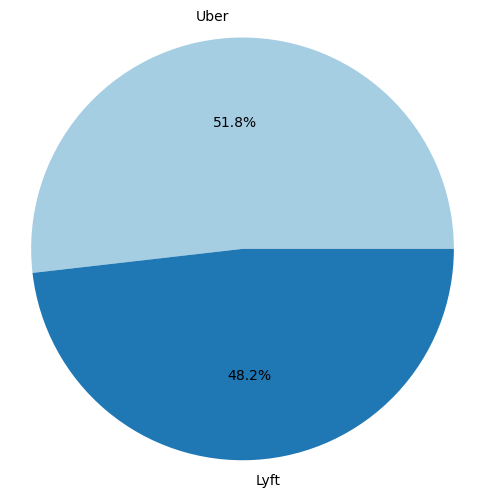

In [38]:
cab_type = df['cab_type'].value_counts()

plt.figure(figsize = (6, 6))
plt.pie(cab_type, labels = cab_type.index, autopct = '%1.1f%%', colors = plt.cm.Paired.colors)
plt.axis('equal')
plt.show()

<Figure size 1200x500 with 0 Axes>

<Axes: >

<Axes: xlabel='name', ylabel='price'>

Text(0.5, 0, 'Car Type')

Text(0, 0.5, 'Price')

Text(0.5, 1.0, 'Lyft: Car Type Pricing')

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Shared'),
  Text(1, 0, 'Lyft'),
  Text(2, 0, 'Lyft XL'),
  Text(3, 0, 'Lux'),
  Text(4, 0, 'Lux Black'),
  Text(5, 0, 'Lux Black XL')])

<Axes: >

<Axes: xlabel='name', ylabel='price'>

Text(0.5, 0, 'Car Type')

Text(0, 0.5, 'Price')

Text(0.5, 1.0, 'Uber: Car Type Pricing')

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'UberPool'),
  Text(1, 0, 'UberX'),
  Text(2, 0, 'WAV'),
  Text(3, 0, 'UberXL'),
  Text(4, 0, 'Black'),
  Text(5, 0, 'Black SUV')])

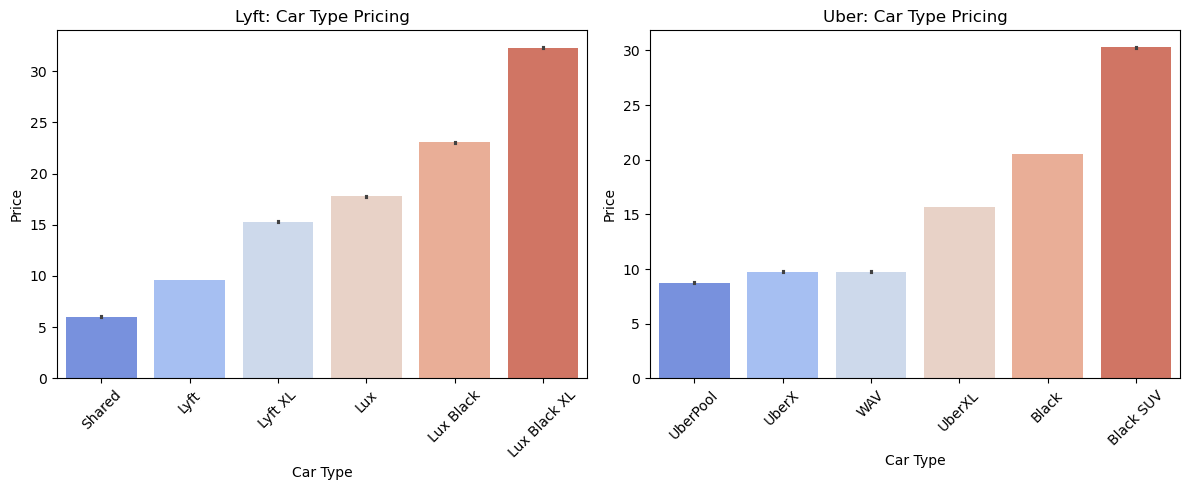

In [39]:
data = df.sort_values("price", ascending = True)

plt.figure(figsize = (12,5))

plt.subplot(1, 2, 1)
sns.barplot(data = data[data.cab_type == "Lyft"], x = "name", y = "price", palette = "coolwarm")
plt.xlabel("Car Type")
plt.ylabel("Price")
plt.title("Lyft: Car Type Pricing")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(data = data[data.cab_type == "Uber"], x = "name", y = "price", palette = "coolwarm")
plt.xlabel("Car Type")
plt.ylabel("Price")
plt.title("Uber: Car Type Pricing")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

- Lyft:
    -  Prices increase consistently with more premium car types
    -  The lowest average price is for Shared, followed by Lyft and Lyft XL
    -  Premium categories like Lux, Lux Black, and Lux Black XL show a steep price rise, with Lux Black XL being the most expensive
<br>
- Uber:
    - UberPool, UberX, and WAV have very similar and lower price ranges
    - Prices rise significantly for UberXL, Black, and especially Black SUV, which is the highest-priced option
<br>
- Both platforms follow a similar pricing tier structure — economy to luxury
- Lyft shows more gradual price increases across tiers, while Uber’s jump from mid-tier to premium is more pronounced
- Luxury options are slightly pricier on Lyft at the very top end (Lux Black XL vs. Black SUV)

<Figure size 1200x500 with 0 Axes>

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Price')

Text(0.5, 1.0, 'Lyft Vs Uber: Distance Vs Price')

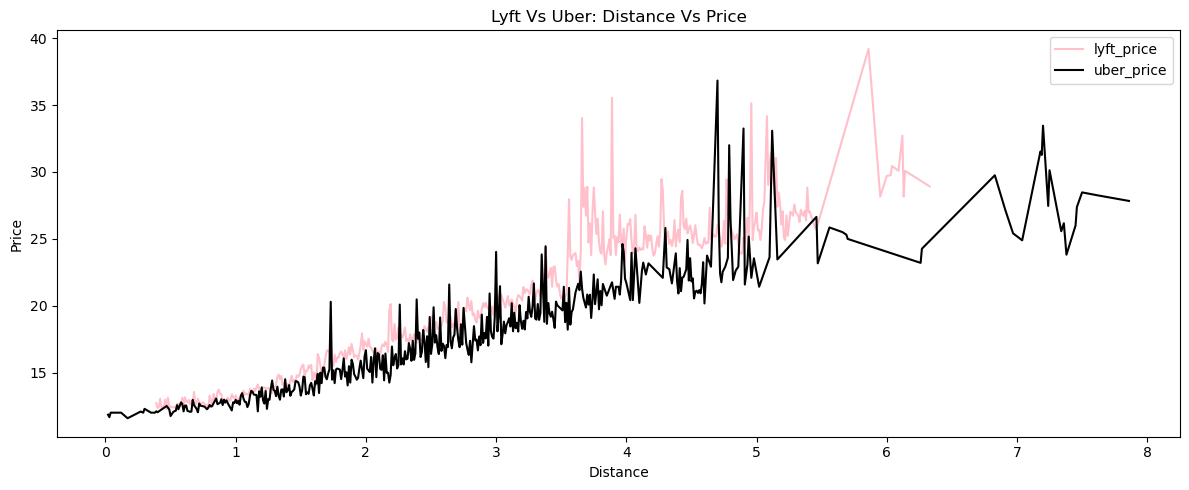

In [41]:
line_data = df[['cab_type', 'distance', 'price']].reset_index().drop('id', axis = 1)
line_data = line_data.set_index('distance')

plt.figure(figsize = (12,5))
plt.plot(line_data[line_data.cab_type == 'Lyft'].groupby('distance')['price'].mean().index, 
         line_data[line_data.cab_type == 'Lyft'].groupby('distance')['price'].mean(), color = 'pink', label = 'lyft_price')
plt.plot(line_data[line_data.cab_type == 'Uber'].groupby('distance')['price'].mean().index, 
         line_data[line_data.cab_type == 'Uber'].groupby('distance')['price'].mean(),color = 'black', label = 'uber_price')
plt.xlabel('Distance')
plt.ylabel('Price')
plt.title('Lyft Vs Uber: Distance Vs Price')
plt.tight_layout()
plt.legend()
plt.show()

- Both Lyft and Uber show a positive correlation between distance and price — as the ride distance increases, the average price increases
<br>
- Lyft:
    - Lyft prices increase more steeply with distance, especially beyond ~2.5 miles
    - Lyft's pricing appears slightly higher than Uber’s in longer distances (4–6+ miles)
<br>
- Uber:
    - Uber prices rise more gradually than Lyft
    - Uber maintains a smoother and more stable price progression over increasing distances
    - In the mid-range (1.5–3.5 miles), Uber is often slightly cheaper than Lyft

<Figure size 1200x500 with 0 Axes>

<Axes: xlabel='hour', ylabel='ride_count'>

Text(0.5, 1.0, 'Hourly Ride Volume: Lyft Vs Uber')

Text(0.5, 0, 'Hour of the Day')

Text(0, 0.5, 'Number of Rides')

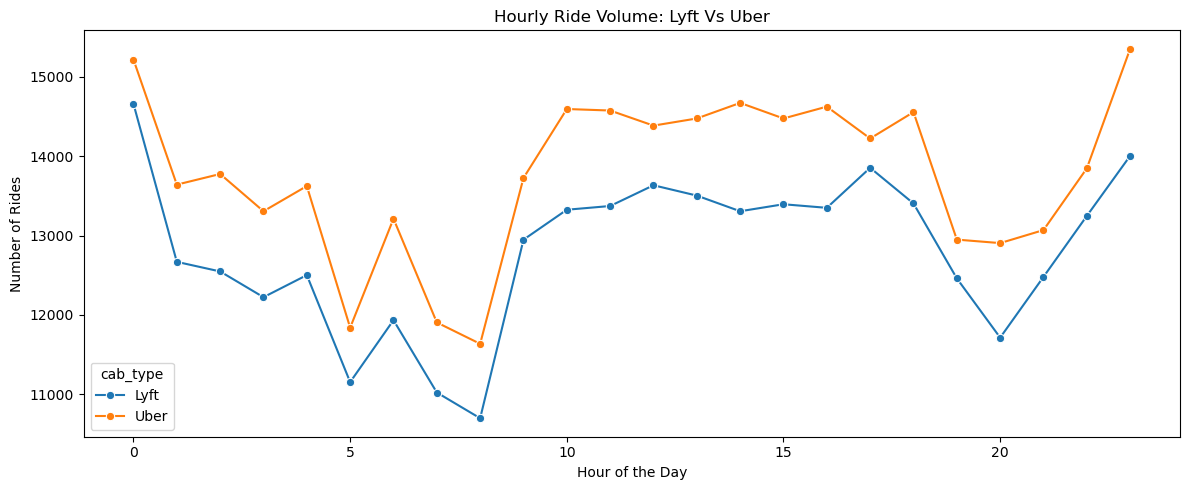

In [43]:
peak_df = df[['cab_type', 'time']].reset_index().drop('id', axis = 1)
peak_df['time'] = pd.to_datetime(peak_df['time'], errors='coerce')
peak_df['hour'] = peak_df['time'].dt.hour

ride_counts_df = peak_df.groupby(['cab_type', 'hour'], as_index = False).size().rename(columns = {"size" : "ride_count"})

plt.figure(figsize = (12, 5))
sns.lineplot(data = ride_counts_df, x = 'hour', y = 'ride_count', hue = 'cab_type', marker = 'o')
plt.title('Hourly Ride Volume: Lyft Vs Uber')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rides')
plt.tight_layout()
plt.show()

- Uber consistently has higher ride volumes than Lyft across nearly all hours
- Late-night and evening hours (after 9 PM) are the busiest periods for both services
- Both services experience dips in demand during early morning (2–6 AM), likely reflecting reduced commuter or leisure activity

### Data Preprocessing

In [46]:
# Define X and y
X = df.drop(columns = 'price')
y = df['price']

# Split the Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

# View the data points from Train and Test sets
print("Number of Data Points in Training Set (75%): {}".format(X_train.shape[0]))
print("Number of Data Points in Test Set (25%): {}".format(X_test.shape[0]))

Number of Data Points in Training Set (75%): 478482
Number of Data Points in Test Set (25%): 159494


In [47]:
# Separate categorical and numerical columns
num_cols = X.select_dtypes(include = ['int64', 'float64']).columns
cat_cols = X.select_dtypes(include = ['object', 'category']).columns

# Pipeline for Numeric Columns
num_pipe = make_pipeline(StandardScaler())

# Pipeline for Categorical Columns
cat_pipe = make_pipeline(OneHotEncoder(handle_unknown = 'ignore'))

# Combine both the pipeline
preprocessor = make_column_transformer(
                                        (num_pipe, num_cols),
                                        (cat_pipe, cat_cols)
                                       )

### Temporary Function

In [49]:
# Base Model Function
def base_model(model, preprocessor, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    models = make_pipeline(preprocessor, model)
    models.fit(X_train, y_train)
    y_train_pred = models.predict(X_train)
    y_test_pred = models.predict(X_test)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = models.score(X_train, y_train)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = models.score(X_test, y_test)
    return print("Train MSE: {:.2f} | Test MSE: {:.2f} | Train R-Squared: {:.2f} | Test R-Squared: {:.2f}".
                 format(train_mse, test_mse, train_r2, test_r2))

# Tuned Model Function
def tuned_model(preprocessor, model, param_grid, label = 'Model_Name', X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    pipe = make_pipeline(preprocessor, model)
    grid = GridSearchCV(pipe, param_grid, cv = 3, n_jobs = -1, return_train_score = True)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = best_model.score(X_train, y_train)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = best_model.score(X_test, y_test)
    print("Best Parameter ({}): {} | Train MSE: {:.2f} | Test MSE: {:.2f} | Train R-Squared: {:.2f} | Test R-Squared: {:.2f}".
                format(label, grid.best_params_, train_mse, test_mse, train_r2, test_r2))

### Model Building

- Linear Regression
- Ridge Regression
- Lasso Regression
- ElasticNet Regression
<br>

Advance Models:
<ul>
    <li>Decision Tree Regression</li>
    <li>XGBoost Regression</li>
    <li>MLP Regression</li>
</ul>

#### Linear Regression

In [53]:
# Base Model: Linear Regression
base_model(LinearRegression(), preprocessor)

Train MSE: 6.01 | Test MSE: 6.30 | Train R-Squared: 0.93 | Test R-Squared: 0.93


#### Ridge Regression

In [55]:
# Base Model: Ridge Regression
base_model(Ridge(), preprocessor)

Train MSE: 6.01 | Test MSE: 6.28 | Train R-Squared: 0.93 | Test R-Squared: 0.93


In [56]:
# Hyperparameter Tuning
param_grid = {
                'ridge__alpha' : [0.01, 0.1, 1, 10, 100]
             }

tuned_model(preprocessor, Ridge(), param_grid, label = "Ridge Regression")

Best Parameter (Ridge Regression): {'ridge__alpha': 100} | Train MSE: 6.12 | Test MSE: 6.20 | Train R-Squared: 0.93 | Test R-Squared: 0.93


#### Lasso Regression

In [58]:
# Base Model: Lasso Regression
base_model(Lasso(), preprocessor)

Train MSE: 59.47 | Test MSE: 59.49 | Train R-Squared: 0.32 | Test R-Squared: 0.32


In [59]:
# Hyperparameter Tuning
param_grid = {
                'lasso__alpha' : [0.001, 0.01, 0.1, 1, 10, 100]
             }

tuned_model(preprocessor, Lasso(), param_grid, label = "Lasso Regression")

Best Parameter (Lasso Regression): {'lasso__alpha': 0.001} | Train MSE: 6.21 | Test MSE: 6.21 | Train R-Squared: 0.93 | Test R-Squared: 0.93


#### ElasticNet Regression

In [61]:
# Base Model: ElasticNet Regression
base_model(ElasticNet(), preprocessor)

Train MSE: 62.20 | Test MSE: 62.23 | Train R-Squared: 0.28 | Test R-Squared: 0.29


In [62]:
# Hyperparameter Tuning
param_grid = {
                'elasticnet__alpha' : [0.001, 0.01, 1, 10, 100],
                'elasticnet__l1_ratio' : [0.25, 0.5, 0.75, 1.0]
             }

tuned_model(preprocessor, ElasticNet(max_iter = 1000), param_grid, label = "ElasticNet Regression")

Best Parameter (ElasticNet Regression): {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 1.0} | Train MSE: 6.21 | Test MSE: 6.21 | Train R-Squared: 0.93 | Test R-Squared: 0.93


**Base Model**

Among the four models — Linear Regression, Ridge Regression, Lasso, and Elastic Net — **Linear and Ridge Regression** performed the best. Both models achieving an R² score of ~0.93 means they are able to explain 93% of the variability in cab prices using the input features.

**Tuned Model**

All four regression models—Linear, Ridge, Lasso, and ElasticNet—achieved strong performance (R² = 0.93) after hyperparameter tuning, with test MSE values around 6.20. While Linear Regression performed well without tuning, both Ridge and Lasso slightly improved test MSE after tuning. However, Lasso and ElasticNet performed poorly with default settings (high MSE and low R²), indicating severe underfitting due to overly strong regularization. Tuning their hyperparameters, especially alpha, significantly improved their performance, aligning them with Ridge and Linear models. This shows that tuning is crucial for regularized models, especially when using Lasso or ElasticNet.

### Advance Model

#### Decision Tree

In [67]:
# Base Model: Decision Tree Regressor
base_model(DecisionTreeRegressor(random_state=42), preprocessor)

Train MSE: 0.01 | Test MSE: 3.57 | Train R-Squared: 1.00 | Test R-Squared: 0.96


In [68]:
# Hyperparameter
param_grid = {
                'decisiontreeregressor__max_depth' : [5, 10, 15, None],
                'decisiontreeregressor__min_samples_split' : [2, 5, 10],
                'decisiontreeregressor__min_samples_leaf' : [1, 2, 4]
             }

tuned_model(preprocessor, DecisionTreeRegressor(random_state = 42), param_grid, label = "Decision Tree Regression")

Best Parameter (Decision Tree Regression): {'decisiontreeregressor__max_depth': 15, 'decisiontreeregressor__min_samples_leaf': 4, 'decisiontreeregressor__min_samples_split': 10} | Train MSE: 2.63 | Test MSE: 2.84 | Train R-Squared: 0.97 | Test R-Squared: 0.97


Hyperparameter tuning successfully improved the Decision Tree's performance by controlling tree complexity, leading to a better balance between bias and variance.

#### XGBoost

In [71]:
# Base Model: XGBoost Regressor
base_model(XGBRegressor(objective='reg:squarederror', random_state = 42), preprocessor)

Train MSE: 2.70 | Test MSE: 2.85 | Train R-Squared: 0.97 | Test R-Squared: 0.97


In [72]:
# Hyperparameter
param_grid = {
                'xgbregressor__n_estimators' : [100, 200],
                'xgbregressor__max_depth' : [3, 5, 7],
                'xgbregressor__learning_rate' : [0.01, 0.1, 0.2],
                'xgbregressor__subsample' : [0.8, 1],
                'xgbregressor__colsample_bytree' : [0.8, 1]
             }

tuned_model(preprocessor, XGBRegressor(objective='reg:squarederror', random_state = 42), param_grid, label = "XGBoost Regression")

Best Parameter (XGBoost Regression): {'xgbregressor__colsample_bytree': 0.8, 'xgbregressor__learning_rate': 0.2, 'xgbregressor__max_depth': 7, 'xgbregressor__n_estimators': 200, 'xgbregressor__subsample': 1} | Train MSE: 2.56 | Test MSE: 2.78 | Train R-Squared: 0.97 | Test R-Squared: 0.97


The base XGBoost model already demonstrated excellent performance with an MSE of 2.85 and an R² of 0.97, indicating strong predictive power and minimal error. After hyperparameter tuning using GridSearchCV, the model slightly improved, achieving a lower test MSE of 2.78 while maintaining the same R² of 0.97. This suggests that tuning optimized the model’s parameters without overfitting, resulting in a well-balanced and robust regression model suitable for production use.

#### Multi Layer Perceptron

In [75]:
# Base Model: MLP Regressor
base_model(MLPRegressor(random_state = 42, max_iter = 1000), preprocessor)

Train MSE: 0.34 | Test MSE: 4.79 | Train R-Squared: 1.00 | Test R-Squared: 0.95


In [76]:
# Hyperparameter
param_grid = {
                'mlpregressor__hidden_layer_sizes' : [(8,), (16,), (16,8)],
                'mlpregressor__activation' : ['relu', 'tanh'],
                'mlpregressor__solver' : ['adam'],
                'mlpregressor__alpha' : [0.0001, 0.001, 0.01],
                'mlpregressor__learning_rate' : ['constant', 'adaptive'],
                'mlpregressor__learning_rate_init' : [0.001, 0.01]
             }

tuned_model(preprocessor, MLPRegressor(random_state=42, max_iter = 1000), param_grid, label = "MLP Regression")

Best Parameter (MLP Regression): {'mlpregressor__activation': 'relu', 'mlpregressor__alpha': 0.01, 'mlpregressor__hidden_layer_sizes': (16, 8), 'mlpregressor__learning_rate': 'constant', 'mlpregressor__learning_rate_init': 0.01, 'mlpregressor__solver': 'adam'} | Train MSE: 2.81 | Test MSE: 2.97 | Train R-Squared: 0.97 | Test R-Squared: 0.97


The base MLP model fit the training data almost perfectly (R² = 1.00, MSE = 0.34) but showed signs of overfitting, with a higher test MSE (4.79) and a performance gap between train and test. After tuning, the model achieved more balanced performance (Train MSE = 2.81, Test MSE = 2.97, both R² = 0.97), indicating reduced overfitting and improved generalization. The smaller architecture, regularization, and adjusted learning rate helped the tuned model trade a small drop in training accuracy for much better reliability on unseen data.

### Conclusion

In [129]:
result = {
'model' : ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'ElasticNet Regression', 'Decision Tree Regression', 'XGBoost Regression', 'MLP Regression'],
'base_train_mse' : [6.01, 6.01, 59.47, 62.20, 0.01, 2.70, 0.34],
'base_test_mse' : [6.30, 6.28, 59.49, 62.23, 3.57, 2.85, 4.79],
'base_train_r2' : [0.93, 0.93, 0.32, 0.28, 1.00, 0.97, 1.00],
'base_test_r2' : [0.93, 0.93, 0.32, 0.29, 0.96, 0.97, 0.95],
'tuned_train_mse' : [0, 6.12, 6.21, 6.21, 2.63, 2.56, 2.81],
'tuned_test_mse' : [0, 6.20, 6.21, 6.21, 2.84, 2.78, 2.97],
'tuned_train_r2' : [0, 0.93, 0.93, 0.93, 0.97, 0.97, 0.97],
'tuned_test_r2' : [0, 0.93, 0.93, 0.93, 0.97, 0.97, 0.97]
        }

metrics_df = pd.DataFrame(result)
metrics_df = metrics_df.set_index('model')
metrics_df

,base_train_mse,base_test_mse,base_train_r2,base_test_r2,tuned_train_mse,tuned_test_mse,tuned_train_r2,tuned_test_r2
model,,,,,,,,
Linear Regression,6.01,6.30,0.93,0.93,0.00,0.00,0.00,0.00
Ridge Regression,6.01,6.28,0.93,0.93,6.12,6.20,0.93,0.93
Lasso Regression,59.47,59.49,0.32,0.32,6.21,6.21,0.93,0.93
ElasticNet Regression,62.20,62.23,0.28,0.29,6.21,6.21,0.93,0.93
Decision Tree Regression,0.01,3.57,1.00,0.96,2.63,2.84,0.97,0.97
XGBoost Regression,2.70,2.85,0.97,0.97,2.56,2.78,0.97,0.97
MLP Regression,0.34,4.79,1.00,0.95,2.81,2.97,0.97,0.97


<Figure size 1000x500 with 0 Axes>

<BarContainer object of 7 artists>

<BarContainer object of 7 artists>

Text(0.5, 0, 'Model')

Text(0, 0.5, 'Test MSE (Lower is Better)')

Text(0.5, 1.0, 'Test MSE Comparison')

([<matplotlib.axis.XTick at 0x166bc43b0>,
 [Text(0.175, 0, 'Linear Regression'),
  Text(1.175, 0, 'Ridge Regression'),
  Text(2.175, 0, 'Lasso Regression'),
  Text(3.175, 0, 'ElasticNet Regression'),
  Text(4.175, 0, 'Decision Tree Regression'),
  Text(5.175, 0, 'XGBoost Regression'),
  Text(6.175, 0, 'MLP Regression')])

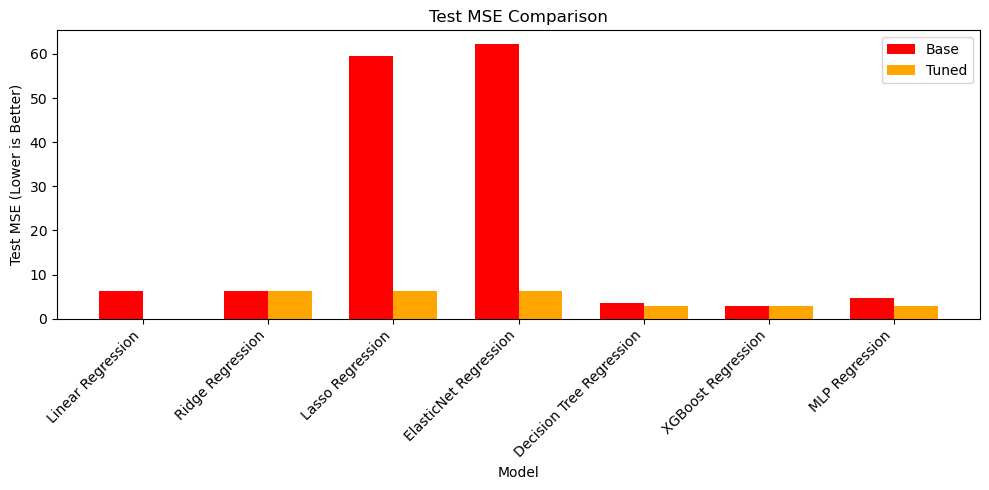

In [143]:
df = metrics_df.reset_index()

# Plot Test MSE comparison
plt.figure(figsize=(10,5))
bar_width = 0.35
index = range(len(df))

plt.bar(index, df['base_test_mse'], bar_width, label='Base', color='red')
plt.bar([i + bar_width for i in index], df['tuned_test_mse'], bar_width, label='Tuned', color='orange')

plt.xlabel('Model')
plt.ylabel('Test MSE (Lower is Better)')
plt.title('Test MSE Comparison')
plt.xticks([i + bar_width/2 for i in index], df['model'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

<BarContainer object of 7 artists>

<BarContainer object of 7 artists>

Text(0.5, 0, 'Model')

Text(0, 0.5, 'Test R² (Higher is Better)')

Text(0.5, 1.0, 'Test R² Comparison')

([<matplotlib.axis.XTick at 0x31ec2b3b0>,
 [Text(0.175, 0, 'Linear Regression'),
  Text(1.175, 0, 'Ridge Regression'),
  Text(2.175, 0, 'Lasso Regression'),
  Text(3.175, 0, 'ElasticNet Regression'),
  Text(4.175, 0, 'Decision Tree Regression'),
  Text(5.175, 0, 'XGBoost Regression'),
  Text(6.175, 0, 'MLP Regression')])

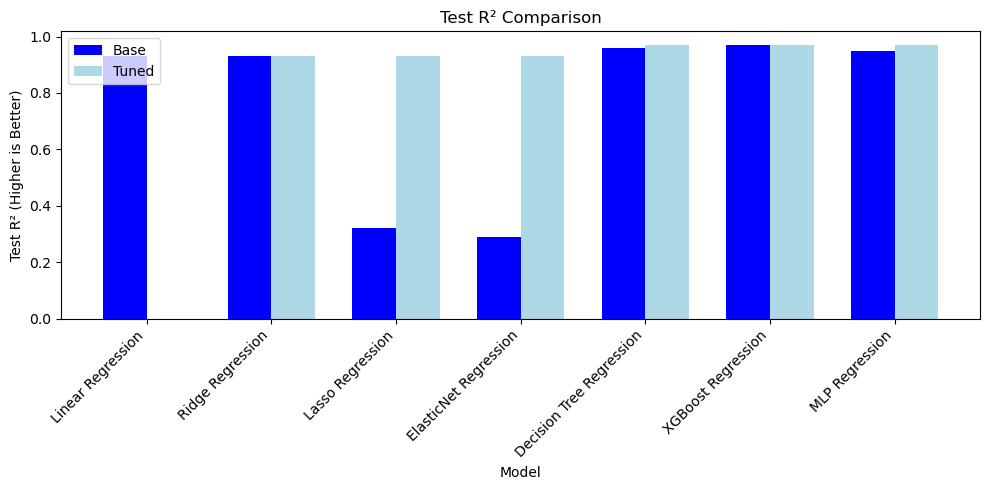

In [141]:
# Plot Test R² comparison
plt.figure(figsize=(10,5))
plt.bar(index, df['base_test_r2'], bar_width, label='Base', color='blue')
plt.bar([i + bar_width for i in index], df['tuned_test_r2'], bar_width, label='Tuned', color='lightblue')

plt.xlabel('Model')
plt.ylabel('Test R² (Higher is Better)')
plt.title('Test R² Comparison')
plt.xticks([i + bar_width/2 for i in index], df['model'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

With the lowest test MSE (2.78) and a high, balanced R² (0.97), the **tuned XGBoost Regression model** provides highly accurate and consistent price predictions. By considering factors like time of day, weather, and trip details, it enables passengers to compare Uber and Lyft fares in real time, helping them choose the most cost-effective option for their ride.